# BilbyAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby runs, including corner plots and evidences

### Imports

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi
#import lal
#import lalsimulation as lalsim
import pesummary
from pesummary.io import read
import json
import os.path
from ipynb.fs.full.Auxiliary import SubtractPeakTime, EllinKm, ComputeOverlap, ComputeMultiDetectorOverlap


# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

t_gps = 1126259462.0
t_start = t_gps - 2.0

### Functions for injection values, Bayes factors, evidences, etc

In [31]:
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['total_mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    TruthDict['m_1'] = params['m_1']
    TruthDict['m_2'] = params['m_2']
    TruthDict['chi_eff'] = params['chi_eff']
    TruthDict['chi_p'] = 0.0 ## Since this is a non-precessing run
    f.close()
    return TruthDict

def GetEvidences(p):
    """ Generate a .dat file for the evidences if it doesn't exist, 
        reading from the json file.
        Returns log_evidence log_evidence_err log_noise_evidence log_bayes_factor """
    
    name = p + "/evidences.dat"
 
    if not os.path.isfile(name):
        
        print("Generating evidences.dat from result.json file")
        
        f_res = open(p + '/fast_tutorial_result.json')
        data = json.load(f_res)
        f_res.close()
      
        f_out = open(name, 'w')
        f_out.write("# log_evidence log_evidence_err log_noise_evidence log_bayes_factor \n")
        f_out.write("%f %f %f %f" % (data['log_evidence'], data['log_evidence_err'], data['log_noise_evidence'], data['log_bayes_factor']))
        f_out.close()

    return np.loadtxt(name, comments="#",usecols=([0,1,2,3]),unpack=True) 

def Ell_SNR_String(ell_string, mass, snr):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km, " % (phys_ell_km.value) + snr
    return string

def Ell_String(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km" % (phys_ell_km.value)
    return string

def SummaryPageFile(name):
    return "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/" + name + \
        "/summary_pages/samples/posterior_samples.h5"

RangeDict = {'mass_ratio': (0.7, 1.0), 'total_mass' : (65.0, 71.0), 'chi_eff' : (-0.1, 0.1), 'chi_p' : (0.0, 1.0), 'luminosity_distance' : (200, 700)}

In [32]:
## Grab the mass
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_75'
TruthDict = GetTruthDict(p)
print(TruthDict['luminosity_distance'])
mass = TruthDict['mass']

601.0372365294345


### One dimensional histograms

mass_ratio, chirp_mass, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, dec, ra, theta_jn, psi, phase, geocent_time, log_likelihood, log_prior, redshift, comoving_distance, inverted_mass_ratio, mass_1, mass_2, total_mass, symmetric_mass_ratio, mass_1_source, mass_2_source, total_mass_source, chirp_mass_source, iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z, phi_1, phi_2, chi_p, chi_p_2spin, chi_eff, beta, psi_J, cos_tilt_1, cos_tilt_2, H1_time, L1_time, V1_time, cos_theta_jn, viewing_angle, cos_iota

0p0 75
0p25 75
0p3 75
0p33 75
0p35 75
0p37 75


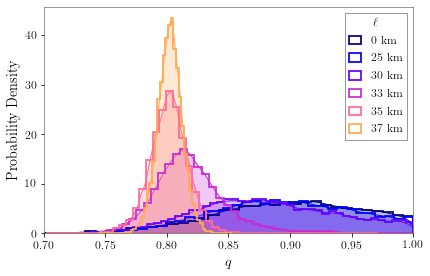

In [54]:
def Histogram(param):

    ells = ['0p0', '0p25', '0p3', '0p33', '0p35', '0p37']
    snrs = ['75' for ell in ells]
    #snrs = ['25', '75', '125']
    #ells = ['0p0' for snr in snrs]
    colors = sns.color_palette('gnuplot2', n_colors=len(snrs) + 1)
    
    fig = plt.figure()
    
    for ell, snr, color in zip(ells, snrs, colors):
        
        print(ell, snr)
        file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + snr)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(param, type="hist", kde=True, color = color, label = Ell_String(ell, mass), fig = fig, plot_percentile = False, title = False)
        
    plt.xlim(RangeDict[param])
    plt.legend(loc = 'upper right', title = '$\ell$')
    plt.grid()
    plt.savefig('kde_' + param)
    plt.show()
    
params_avail = ["mass_ratio", "chirp_mass", "a_1", "a_2", "tilt_1", "tilt_2", \
                "phi_12", "phi_jl", "luminosity_distance", "dec", "ra", \
                "theta_jn", "psi", "phase", "geocent_time", "total_mass", \
                "symmetric_mass_ratio", "iota", "phi_1", "phi_2", "chi_p", "chi_p_2spin", \
                "chi_eff", "beta", "psi_J", "cos_tilt_1", "cos_tilt_2", "H1_time", \
                "L1_time", "V1_time", "cos_theta_jn", "viewing_angle", "cos_iota"]
#Histogram("chi_p")
Histogram("mass_ratio")
#Histogram("chi_eff")


In [13]:
base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
parameters = ['mass_ratio', 'luminosity_distance', 'total_mass', 'chi_p', 'chi_eff']
truths = [TruthDict[param] for param in parameters]
ranges = [RangeDict[param] for param in parameters]

dim = len(parameters) 
    
file_name = SummaryPageFile('PHENOM_dCS_0p35_75')
data = read(file_name)
samples_dict = data.samples_dict
posterior_samples = samples_dict["summary_pages"]
   

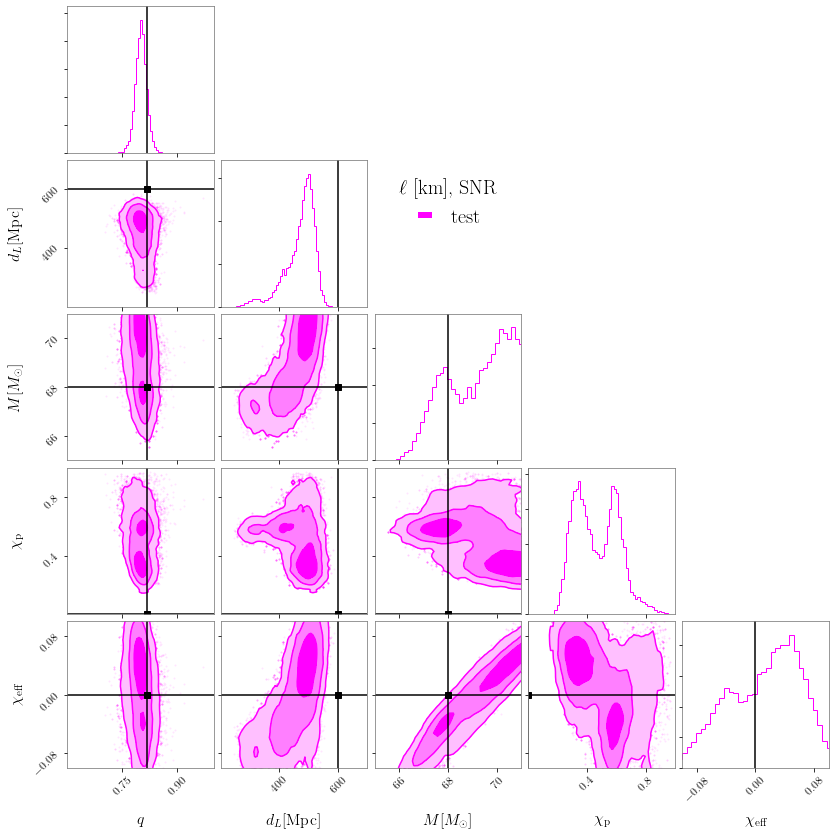

In [14]:
fig, ax_arr = plt.subplots(dim, dim, figsize=(12, 12))
handles = []
posterior_samples.plot(type="corner",
                         parameters=parameters, fig = fig, color = 'magenta', truths=truths, truth_color='black', \
                           quantiles=[])

l = ax_arr[1][2].plot([0,0], [0,0], label='test', color = 'magenta')
handles.append(l[0])

legend = ax_arr[1][2].legend(handles=handles, frameon=False, title = r'$\ell$ [km], SNR', loc = 'upper center', fontsize=20)

for i in range(5):
    ax_arr[i][0].set_xlim(RangeDict['mass_ratio'])
    ax_arr[i][1].set_xlim(RangeDict['luminosity_distance'])
    ax_arr[i][2].set_xlim(RangeDict['total_mass'])
    ax_arr[i][3].set_xlim(RangeDict['chi_p'])
    ax_arr[i][4].set_xlim(RangeDict['chi_eff'])


ax_arr[1][0].set_ylim(RangeDict['luminosity_distance'])
ax_arr[2][0].set_ylim(RangeDict['total_mass'])
ax_arr[2][1].set_ylim(RangeDict['total_mass'])
ax_arr[3][0].set_ylim(RangeDict['chi_p'])
ax_arr[3][1].set_ylim(RangeDict['chi_p'])
ax_arr[3][2].set_ylim(RangeDict['chi_p'])
ax_arr[4][0].set_ylim(RangeDict['chi_eff'])
ax_arr[4][1].set_ylim(RangeDict['chi_eff'])
ax_arr[4][2].set_ylim(RangeDict['chi_eff'])
ax_arr[4][3].set_ylim(RangeDict['chi_eff'])


for ax in fig.get_axes():
    ax.grid(False)
    
plt.setp(legend.get_title(),fontsize=20)
#plt.tight_layout()
plt.show()


[(0.6, 1.0), (65.0, 71.0), (0.0, 1.0), (-0.1, 0.1)]
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_125/summary_pages/samples/posterior_samples.h5
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p37_125/summary_pages/samples/posterior_samples.h5


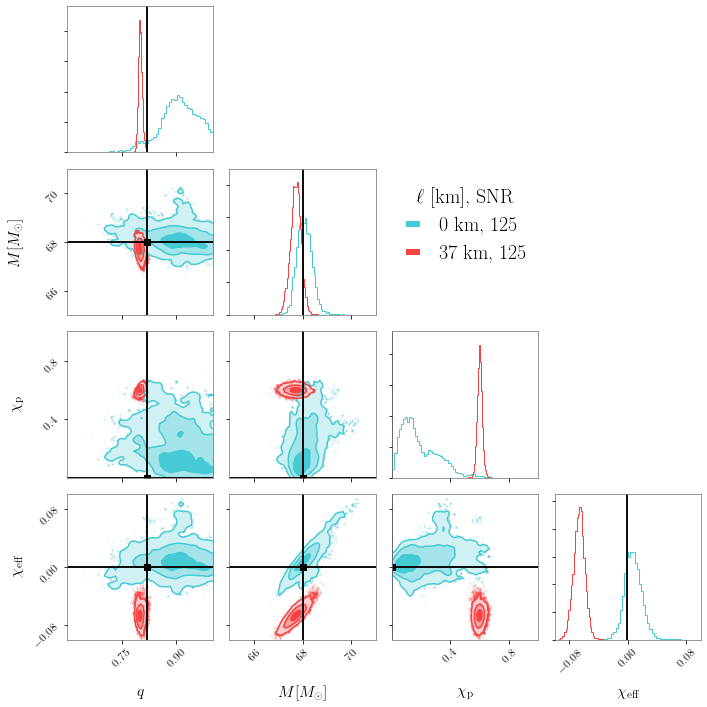

In [51]:
def CornerPlot(cmap):
    """ Make a corner plot of Bilby runs on GR injections with various SNRs"""

    base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    parameters = ['mass_ratio', 'total_mass', 'chi_p', 'chi_eff']
    truths = [TruthDict[param] for param in parameters]
    ranges = [RangeDict[param] for param in parameters]
    print(ranges)
    dim = len(parameters) 

    ells = ['0p0', '0p37']
    snrs = ['125' for ell in ells]
    colors = sns.color_palette(cmap, n_colors=len(snrs) + 1)
    colors = ['#46cad4', '#f54242']
    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10, 10))
    handles = []
    
    for ell, snr, c in zip(ells, snrs, colors):
        
        file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + snr)
        print(file_name)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(type="corner",
                             parameters=parameters, fig = fig, color = c, truths=truths, truth_color='black', \
                               quantiles=[], range=ranges)
    
        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot([0,0], [0,0], label=Ell_SNR_String(ell, mass, snr), color = c)
        handles.append(l[0])

    ## Plot the injected values myself
    
    legend = ax_arr[1][2].legend(handles=handles, frameon=False, title = r'$\ell$ [km], SNR', loc = 'upper center', fontsize=20)
    
    for i in range(4):
        ax_arr[i][0].set_xlim(RangeDict['mass_ratio'])
        ax_arr[i][1].set_xlim(RangeDict['total_mass'])
        ax_arr[i][2].set_xlim(RangeDict['chi_p'])
        ax_arr[i][3].set_xlim(RangeDict['chi_eff'])
        
    ax_arr[1][0].set_ylim(RangeDict['total_mass'])
    ax_arr[2][0].set_ylim(RangeDict['chi_p'])
    ax_arr[2][1].set_ylim(RangeDict['chi_p'])
    ax_arr[3][0].set_ylim(RangeDict['chi_eff'])
    ax_arr[3][1].set_ylim(RangeDict['chi_eff'])
    ax_arr[3][2].set_ylim(RangeDict['chi_eff'])

    plt.setp(legend.get_title(),fontsize=20)
    
    for ax in fig.get_axes():
        ax.grid(False)

    plt.tight_layout()
    plt.savefig('dCSCorner_125.pdf')
    plt.show()
    
CornerPlot('plasma')  

### Plot Bayes factors as a function of SNR Bilby runs

0p0 25 297.682087
0p0 75 2949.158425
0p0 125 8279.95828
0p25 25 297.811283
0p25 75 2947.30526
0p25 125 8273.319306
0p3 25 295.263237
0p3 75 2935.553395
0p3 125 8248.99412
0p37 25 283.584561
0p37 75 2875.249547
0p37 125 8098.943613


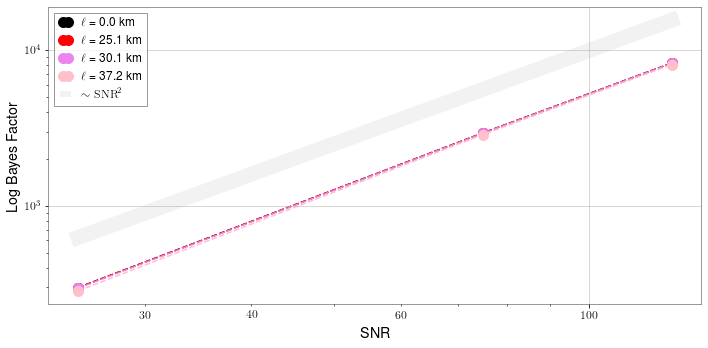

In [86]:
def PlotBayesSNR():
    """ Plot Bayes factors for various dCS parameters as a function of SNR """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68
    
    ells = ["0p0", "0p25", "0p3", "0p37"]
    colors = ['black', 'red', 'violet', 'pink', 'lightblue', 'orange']
    snrs = [25, 75, 125]
    
    plt.figure(figsize=(10, 5))
    
    for ell, color in zip(ells, colors):

        bayes_arr = []

        for snr in snrs:

            p = base_dir + "PHENOM_dCS_" + ell + "_" + str(snr)  + "/outdir_fref"
            log_evidence, log_evidence_err, log_noise_evidence, log_bayes_factor = GetEvidences(p)
            print(ell, snr, log_bayes_factor)
            bayes_arr.append(log_bayes_factor)

        plt.plot(snrs, bayes_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)
        
    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**2.0
    plt.plot(SNRS, snr_curve, color='gray', label = r'$\sim \mathrm{SNR}^{2}$', alpha = 0.1, lw = 15.0)

    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Log Bayes Factor')
    plt.xlabel('SNR')
    plt.tight_layout()
    plt.savefig('BayesSNR.pdf')
    plt.show()
    
#PlotBayesSNR()

### Plot Bayes factors as a function of $\ell$ for Bilby Runs

0p0
0.297042
0p25
0.299385
0p3
0.305257
0p33
0.325573
0p35
0.33249
0p37
0.350839
[-51.028021, -54.154522, -64.237298, -83.239702, -100.283522, -117.185273]
[-3001.530233, -3001.493688, -3001.417232, -3001.327918, -3001.246504, -3001.149646]
[2950.502212, 2947.339166, 2937.179934, 2918.088216, 2900.962983, 2883.964373]


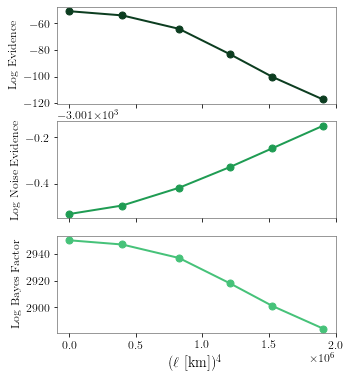

In [9]:
def PlotBayesEll():

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ell_vals = [EllinKm(ell, mass) for ell in ells]
    snr = 75

    log_evidences = [] 
    log_evidence_errs = [] 
    log_noise_evidences = [] 
    log_bayes_factors = []

    for ell in ells:

        print(ell)
        p = base_dir + "PHENOM_dCS_" + ell + "_" + str(snr) + "/outdir_fref"
        log_evidence, log_evidence_err, log_noise_evidence, log_bayes_factor = GetEvidences(p)
        print(log_evidence_err)
        
        log_evidences.append(log_evidence)
        log_noise_evidences.append(log_noise_evidence)
        log_bayes_factors.append( log_bayes_factor)

    fig, axes = plt.subplots(3, figsize=(5,6), sharex = True)

    print(log_evidences)
    print(log_noise_evidences)
    print(log_bayes_factors)
    
    axes[0].plot(np.array(ell_vals)**4, log_evidences, '-o', color = '#0c3d20', markersize = 7, lw = 2.0)
    axes[1].plot(np.array(ell_vals)**4, log_noise_evidences, '-o', color = '#1f9c53', markersize = 7, lw = 2.0)
    axes[2].plot(np.array(ell_vals)**4, log_bayes_factors, '-o', color = '#46c279',  markersize = 7, lw = 2.0)

    fs = 12
    axes[0].set_ylabel('Log Evidence', fontsize=fs)
    axes[1].set_ylabel('Log Noise Evidence', fontsize=fs)
    axes[2].set_ylabel('Log Bayes Factor', fontsize=fs)
    

    for ax in axes:
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.grid()

    plt.subplots_adjust(hspace=0.18)
    plt.xlabel(r'($\ell$ [km])${}^4$')
    #plt.tight_layout()
    plt.savefig('BayesEll.pdf')
    plt.show()
    
PlotBayesEll()

## Plot Bilby Reconstructed Waveforms

In [33]:
def GetBilbyReconstruction(p, det = 'L1'):

    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' 
    bi_p = base_dir + p + '/LI_reconstruct/'
    bw_p = base_dir + p + '/BayesWave/Run/trigtime_1126259462.000000000_0.0_0.0_0/'
    
    h_bw_inj = np.loadtxt(bw_p + 'post/whitened_data_' + det + '.dat')
    t_bw_inj = np.array([1.0/2048 * t for t in range(len(h_bw_inj))])
    t_bw_inj = t_bw_inj + t_start
    
    t_bi, map_bi, lo_bi, hi_bi = \
        np.loadtxt(bi_p + det + '_summary_waveforms_samples.dat', \
        comments="#",usecols=([0,1,3,5]),unpack=True)
    
    return t_bw_inj, h_bw_inj, t_bi, map_bi, lo_bi, hi_bi

def PlotBilbyRec(p, ax, color, det = 'L1', label = "", legend = False):
    
    t_bw_inj, h_bw_inj, t_bi, map_bi, lo_bi, hi_bi = GetBilbyReconstruction(p, det = det)
    
    ax.fill_between(t_bi, lo_bi, hi_bi, color = color, alpha = 0.5)
    ax.plot(t_bi, map_bi, '-', lw = 1.0, alpha = 1.0, color=color, label = r'Max $\mathcal{L}$')  
    ax.plot(t_bw_inj, h_bw_inj, '--', lw = 1.0, alpha = 1.0, color='black', label = 'Injected')  
        
    ## Label ell and SNR
    ax.text(0.02, 0.1, label, horizontalalignment='left',
     verticalalignment='center', transform=ax.transAxes, fontsize=18)
    
    ax.tick_params(axis='x', which='both', bottom=True, top=False) 
    ax.set_xlim(t_gps - 0.07, t_gps + 0.02)
    ax.grid(False)
    
    if legend:
        # add legend to plot
        ax.legend(frameon=True, fontsize=12, loc='upper left')

        
def PlotBilbyReconstruction():

    det = "L1"
    
    fig, axarr = plt.subplots(3,3, figsize=(16, 14), sharex=True, sharey=False)

    mass = 68.0 ## Injected mass

    ell = "0p0"
    color = '#0c57b3'
    PlotBilbyRec("PHENOM_dCS_" + ell + "_25", axarr[0][0], color, det = det, \
                   label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotBilbyRec("PHENOM_dCS_" + ell + "_75", axarr[1][0], color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotBilbyRec("PHENOM_dCS_" + ell + "_125", axarr[2][0], color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))

    ell = "0p33"
    PlotBilbyRec("PHENOM_dCS_" + ell + "_25", axarr[0][1], color, det = det, \
                    label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotBilbyRec("PHENOM_dCS_" + ell + "_75", axarr[1][1], color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotBilbyRec("PHENOM_dCS_" + ell + "_125", axarr[2][1], color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))
    
    ell = "0p37"
    PlotBilbyRec("PHENOM_dCS_" + ell + "_25", axarr[0][2], color, det = det, \
                    label = r'SNR = 25, $\ell$ = %.1f km' % EllinKm(ell, mass), legend = True)
    PlotBilbyRec("PHENOM_dCS_" + ell + "_75", axarr[1][2], color, det = det, \
                   label = r'SNR = 75, $\ell$ = %.1f km' % EllinKm(ell, mass))
    PlotBilbyRec("PHENOM_dCS_" + ell + "_125", axarr[2][2], color, det = det, \
                   label = r'SNR = 125, $\ell$ = %.1f km' % EllinKm(ell, mass))

    for i in range(3):
        axarr[-1][i].set_xlabel('time (sec)', fontsize = 18)
        axarr[i][0].set_ylabel('Whitened waveform in ' + det, ha='center', labelpad = 4.0, rotation='vertical', fontsize=18)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    plt.savefig('Bilby.pdf')
    #plt.tight_layout()
    plt.show()


#PlotBilbyReconstruction()

## Plot Bilby Mismatches

/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_25/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p25_25/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p3_25/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p33_25/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p35_25/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p37_25/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_125/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p25_125/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p3_125/LI_reconstruct/bilby_overlaps.dat
/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p33_125/LI_reconstruct/bilby_overlaps.dat


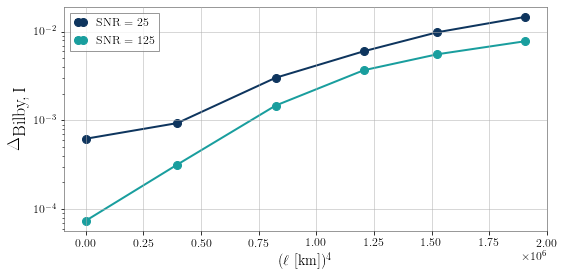

In [37]:
def BilbyOverlap(p):
    """ Given a run directory p, read in the injected and recovered hs in the 
        time domain and compute an overlap """
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/' 
    bi_p = p + '/LI_reconstruct/'
        
    ## Check for file with computed multi-detector bilby overlap 
    name = base_dir + p + "/LI_reconstruct/bilby_overlaps.dat"
    print(name)

    if not os.path.isfile(name):
        
        print("Generating bilby_overlaps.dat file")
    
        t_inj_H1, h_inj_H1, t_bi_H1, h_bi_H1, d, d = GetBilbyReconstruction(p, det = "H1")
        t_inj_L1, h_inj_L1, t_bi_L1, h_bi_L1, d, d = GetBilbyReconstruction(p, det = "L1")
        t_inj_V1, h_inj_V1, t_bi_V1, h_bi_V1, d, d = GetBilbyReconstruction(p, det = "V1")

        overlap_H1 = ComputeOverlap(t_bi_H1, h_bi_H1, t_inj_H1, h_inj_H1)
        overlap_L1 = ComputeOverlap(t_bi_L1, h_bi_L1, t_inj_L1, h_inj_L1)
        overlap_V1 = ComputeOverlap(t_bi_V1, h_bi_V1, t_inj_V1, h_inj_V1)
        
        overlap_all = ComputeMultiDetectorOverlap(t_bi_H1, h_bi_H1, \
                                  t_bi_L1, h_bi_L1, \
                                  t_bi_V1, h_bi_V1, \
                                  t_inj_H1, h_inj_H1, \
                                  t_inj_L1, h_inj_L1, \
                                  t_inj_V1, h_inj_V1)
        
        print('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out = open(name, 'w')
        f_out.write('# Overlap between injected and median reconstructed bilby waveforms \n # overlap_H1 overlap_L1 overlap_V1 overlap_all \n')
        f_out.write('%f %f %f %f' % (overlap_H1, overlap_L1, overlap_V1, overlap_all))
        f_out.close()
    
    overlap_H1, overlap_L1, overlap_V1, overlap_all = np.loadtxt(name, comments="#",usecols=([0, 1, 2, 3]),unpack=True)
    return overlap_all


def PlotBilbyOverlap():
    """ Create a plot of the overlap between BW injected and recovered waveforms as
        a function of SNR. Similar to Fig. 4 in https://arxiv.org/abs/2003.09456 """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35",  "0p37"]
    ell_vals = np.array([EllinKm(ell, mass) for ell in ells])**4
    colors = ["#0e355e", "#199e9e", "#67c97e"]
    snrs = ['25', '125']

    plt.figure(figsize=(8, 4))

    for snr, color in zip(snrs, colors):

        delta_arr = []

        for ell in ells:

            p = "PHENOM_dCS_" + ell + "_" + snr
            overlap = BilbyOverlap(p)
            delta = 1.0 - overlap
            delta_arr.append(delta)

        plt.plot(ell_vals, delta_arr, '-o', color = color, label = 'SNR = ' + snr, markersize = 8, lw = 2.0)

    plt.legend(fontsize=12)
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel(r'$\Delta_\textrm{Bilby,\,I}$', fontsize=18)
    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.tight_layout()
    plt.savefig('BilbyMismatch.pdf')
    plt.show()
    
PlotBilbyOverlap()
